In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from utils.make_txt import *

In [2]:
ucm_vqa_dir = "../data/ucm_vqa.txt"
ucm_images = "../data/ucm_images.txt"

In [4]:
class UCM_RS(Dataset):
    """
    UCM RS dataset.
    """
    def __init__(self, qa_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.qa_file = qa_file
        self.qst, self.ans = read_label_txt(self.qa_file)
        with open(self.img_dir) as f:
            self.img = [line.strip() for line in f.readlines()]
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        """
        to support the indexing such that dataset[i] can be used to get i-th sample.
        * leave the reading of images to __getitem__ to keep the memory efficient because all the images are not stored in the memory at once but read as required.
        :param idx:
        :return:
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = plt.imread(self.img[idx])
        qst = self.qst[idx]
        ans = self.ans[idx]
        sample = {'image': img, 'question': qst, 'answer': ans}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
ucm_vqa_dataset = UCM_RS(qa_file=ucm_vqa_dir, img_dir=ucm_images)
sample = ucm_vqa_dataset[1]
print(sample['image'].shape)

(256, 256, 3)


In [20]:
# Transformers
from skimage import transform
class Rescale(object):
    """
    Rescale the image in a sample to a given size
    output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, qst, ans = sample['image'], sample['question'], sample['answer']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'question': qst, 'answer':ans}

In [39]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, qst, ans = sample['image'], sample['question'], sample['answer']

        h, w = torch.tensor(image.shape[:2])
        new_h, new_w = torch.tensor(self.output_size)

        print(new_w, new_h)

        top = h.random_(0, h - new_h)
        left = w.random_(0, w - new_w)

        img = image[top: top + new_h,
                      left: left + new_w]

        return {'image': img, 'question': qst, 'answer':ans}

In [40]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, qst, ans = sample['image'], sample['question'], sample['answer']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'question': qst, 'answer':ans}

In [41]:
def show_landmarks(image,question,answer):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

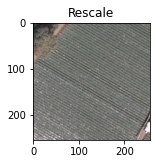

tensor(128) tensor(128)


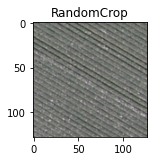

tensor(128) tensor(128)


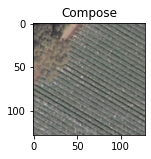

In [44]:
scale = Rescale(256)
crop = RandomCrop(128)
# torchvision.transforms.Compose
composed = transforms.Compose([Rescale(256),
                               RandomCrop(128)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = ucm_vqa_dataset[0]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [46]:
ucm_vqa_dataset = UCM_RS(qa_file=ucm_vqa_dir, img_dir=ucm_images)
transformed_dataset = UCM_RS(
    qa_file=ucm_vqa_dir,
    img_dir=ucm_images,
    transform=transforms.Compose([Rescale(225),RandomCrop(128),ToTensor()])
)
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['question'], sample['answer'])

    if i == 3:
        break

tensor(128) tensor(128)
0 torch.Size([3, 128, 128]) what is the theme of this picture farmland
tensor(128) tensor(128)
1 torch.Size([3, 128, 128]) what is the theme of this picture farmland
tensor(128) tensor(128)
2 torch.Size([3, 128, 128]) what is the theme of this picture farmland
tensor(128) tensor(128)
3 torch.Size([3, 128, 128]) what is the theme of this picture farmland


In [48]:
# Batching the data
# Shuffling the data
# Load the data in parallel using multiprocessing workers

# torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['question'], sample_batched['answer'])
    if i_batch == 3:
        break

tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
0 torch.Size([4, 3, 128, 128]) ['what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture'] ['parking lot', 'intersection', 'river', 'baseball diamond']
tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
1 torch.Size([4, 3, 128, 128]) ['what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture'] ['tennis court', 'forest', 'parking lot', 'airplane']
tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
tensor(128) tensor(128)
2 torch.Size([4, 3, 128, 128]) ['what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture', 'what is the theme of this picture'] ['farmland', 'medium residential', 'forest', 'storage tan